In [1]:
import os
import time

import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

/anaconda3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## 1. Load Data

In [2]:
df_movies = pd.read_csv('./movielens100k/movies.csv',
    usecols=['movie_id', 'title'],
    dtype={'movie_id': 'int32', 'title': 'str'})

df_ratings = pd.read_csv('./movielens100k/ratings.csv',
    usecols=['user_id', 'movie_id', 'rating'],
    dtype={'user_id': 'int32', 'movie_id': 'int32', 'rating': 'float32'})

In [3]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 2 columns):
movie_id    9125 non-null int32
title       9125 non-null object
dtypes: int32(1), object(1)
memory usage: 107.0+ KB


In [4]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 3 columns):
user_id     100004 non-null int32
movie_id    100004 non-null int32
rating      100004 non-null float32
dtypes: float32(1), int32(2)
memory usage: 1.1 MB


In [5]:
df_movies.head()

,movie_id,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [6]:
df_ratings.head()

,user_id,movie_id,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [7]:
num_users = len(df_ratings.user_id.unique())
num_items = len(df_ratings.movie_id.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 671 unique users and 9066 unique movies in this data set


## 2. Exploratory data analysis
 - Plot the counts of each rating
 - Plot rating frequency of each movie

#### 1. Plot the counts of each rating

we first need to get the counts of each rating from ratings data

In [8]:
# get count
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
0.5,1101
1.0,3326
1.5,1687
2.0,7271
2.5,4449
3.0,20064
3.5,10538
4.0,28750
4.5,7723


We can see that above table does not include counts of zero rating score. So we need to add that in rating count dataframe as well

In [9]:
# there are a lot more counts in rating of zero
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]
# append counts of zero rating to df_ratings_cnt
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,5983282
0.5,1101
1.0,3326
1.5,1687
2.0,7271
2.5,4449
3.0,20064
3.5,10538
4.0,28750
4.5,7723


The count for zero rating score is too big to compare with others. So let's take log transform for count values and then we can plot them to compare

In [10]:
# add log count
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,5983282,15.604480
0.5,1101,7.003974
1.0,3326,8.109526
1.5,1687,7.430707
2.0,7271,8.891649
2.5,4449,8.400435
3.0,20064,9.906682
3.5,10538,9.262743
4.0,28750,10.266393
4.5,7723,8.951958


Text(0, 0.5, 'number of ratings')

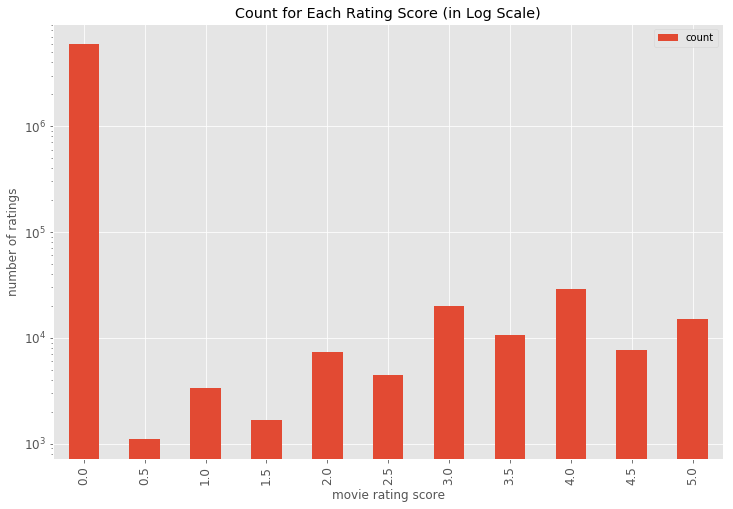

In [11]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

It's interesting that there are more people giving rating score of 3 and 4 than other scores 

#### 2. Plot rating frequency of all movies

In [12]:
df_ratings.head()

,user_id,movie_id,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [13]:
# get rating frequency
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movie_id').size(), columns=['count'])
df_movies_cnt.head()

,count
movie_id,
1,247
2,107
3,59
4,13
5,56


Text(0, 0.5, 'number of ratings')

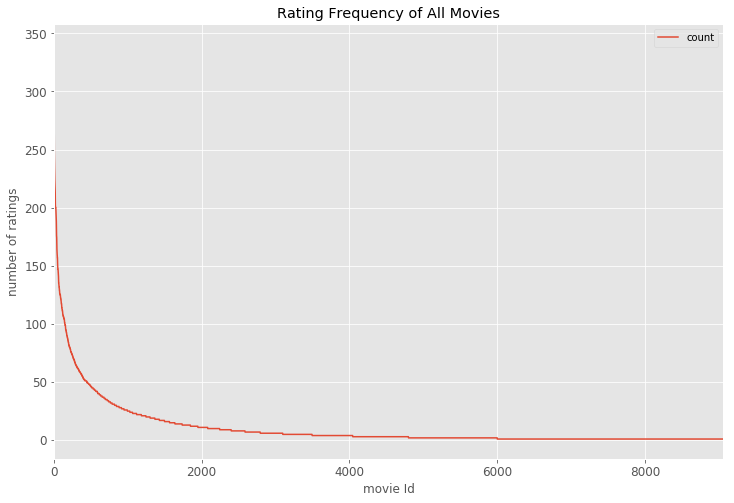

In [14]:
# plot rating frequency of all movies
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

The distribution of ratings among movies often satisfies a property in real-world settings,
which is referred to as the long-tail property. According to this property, only a small
fraction of the items are rated frequently. Such items are referred to as popular items. The
vast majority of items are rated rarely. This results in a highly skewed distribution of the
underlying ratings.

Let's plot the same distribution but with log scale

Text(0, 0.5, 'number of ratings (log scale)')

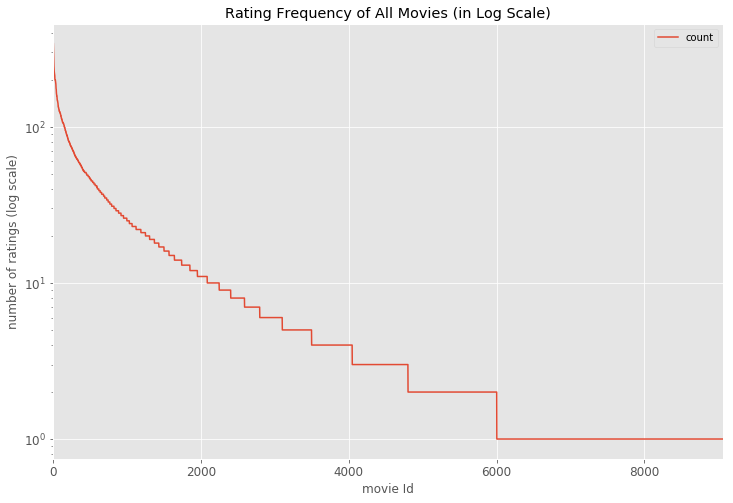

In [15]:
# plot rating frequency of all movies in log scale
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings (log scale)")

We can see that roughly 10,000 out of 53,889 movies are rated more than 100 times. More interestingly, roughly 20,000 out of 53,889 movies are rated less than only 10 times. Let's look closer by displaying top quantiles of rating counts

In [16]:
df_movies_cnt['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    341.0
0.95     49.0
0.90     28.0
0.85     19.0
0.80     13.0
0.75      9.0
0.70      7.0
0.65      5.0
Name: count, dtype: float64

So about 1% of movies have roughly 97,999 or more ratings, 5% have 1,855 or more, and 20% have 100 or more. Since we have so many movies, we'll limit it to the top 25%. This is arbitrary threshold for popularity, but it gives us about 13,500 different movies. We still have pretty good amount of movies for modeling. There are two reasons why we want to filter to roughly 13,500 movies in our dataset.
 - Memory issue: we don't want to run into the “MemoryError” during model training
 - Improve KNN performance: lesser known movies have ratings from fewer viewers, making the pattern more noisy. Droping out less known movies can improve recommendation quality

In [17]:
# filter data
popularity_thres = 50
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movie_id.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (100004, 3)
shape of ratings data after dropping unpopular movies:  (43083, 3)


After dropping 75% of movies in our dataset, we still have a very large dataset. So next we can filter users to further reduce the size of data

In [18]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('user_id').size(), columns=['count'])
df_users_cnt.head()

,count
user_id,
1,3
2,56
3,30
4,106
5,76


Text(0, 0.5, 'number of ratings')

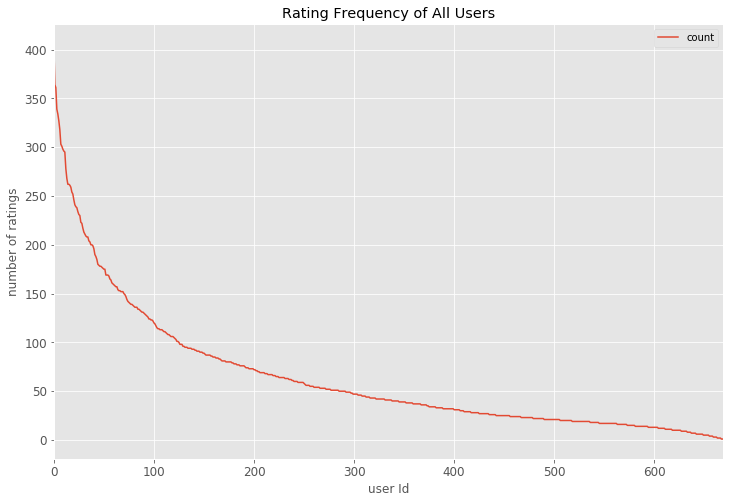

In [19]:
# plot rating frequency of all movies
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings")

In [20]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    406.00
0.95    208.00
0.90    152.10
0.85    119.65
0.80     94.20
0.75     81.75
0.70     72.00
0.65     62.85
0.60     53.00
0.55     47.00
Name: count, dtype: float64

We can see that the distribution of ratings by users is very similar to the distribution of ratings among movies. They both have long-tail property. Only a very small fraction of users are very actively engaged with rating movies that they watched. Vast majority of users aren't interested in rating movies. So we can limit users to the top 40%, which is about 113,291 users.

In [21]:
# filter data
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.user_id.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (100004, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (34044, 3)


## 3. Train KNN model for item-based collaborative filtering
 - Reshaping the Data
 - Fitting the Model

#### 1. Reshaping the Data
For K-Nearest Neighbors, we want the data to be in an (artist, user) array, where each row is a movie and each column is a different user. To reshape the dataframe, we'll pivot the dataframe to the wide format with movies as rows and users as columns. Then we'll fill the missing observations with 0s since we're going to be performing linear algebra operations (calculating distances between vectors). Finally, we transform the values of the dataframe into a scipy sparse matrix for more efficient calculations.

In [22]:
# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index='movie_id', columns='user_id', values='rating').fillna(0)
# create mapper from movie title to index
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movie_id').loc[movie_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [23]:
movie_user_mat.head()

user_id,2,4,5,7,8,15,17,19,20,21,...,647,648,649,654,655,659,662,664,665,671
movie_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,3.0,0.0,2.0,0.0,3.0,3.5,0.0,...,4.0,0.0,4.0,5.0,0.0,0.0,0.0,3.5,0.0,5.0
2,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,3.0,4.0,0.0,5.0,0.0,3.0,0.0
3,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
5,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0
6,0.0,0.0,0.0,0.0,0.0,4.0,4.5,3.0,0.0,0.0,...,4.0,4.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,0.0


In [24]:
movie_user_mat_sparse2 = pd.DataFrame(movie_user_mat_sparse)

#### 2. Fitting the Model
Time to implement the model. We'll initialize the NearestNeighbors class as model_knn and fit our sparse matrix to the instance. By specifying the metric = cosine, the model will measure similarity bectween artist vectors by using cosine similarity.

## 4. Use this trained model to make movie recommendations to myself

In [26]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]



def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1} with distance {2:.4f}'.format(i+1, reverse_mapper[idx], dist))

In [25]:
model_knn = NearestNeighbors(metric='euclidean', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [27]:
my_favorite = 'Toy Story'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=20)

You have input movie: Toy Story
Found possible matches in our database: ['Toy Story (1995)', 'Toy Story 2 (1999)']

Recommendation system start to make inference
......

Recommendations for Toy Story:
1: Big (1988) with distance 44.4185
2: Spider-Man (2002) with distance 44.4156
3: Dumb & Dumber (Dumb and Dumber) (1994) with distance 44.3227
4: Truman Show, The (1998) with distance 43.9574
5: Pirates of the Caribbean: The Curse of the Black Pearl (2003) with distance 43.7921
6: Titanic (1997) with distance 43.7464
7: Sixth Sense, The (1999) with distance 43.2030
8: Finding Nemo (2003) with distance 42.9156
9: Babe (1995) with distance 42.7727
10: Aladdin (1992) with distance 42.6468
11: Lion King, The (1994) with distance 42.6351
12: Shrek (2001) with distance 42.5029
13: Jurassic Park (1993) with distance 42.3379
14: Incredibles, The (2004) with distance 41.9911
15: Independence Day (a.k.a. ID4) (1996) with distance 41.7493
16: Men in Black (a.k.a. MIB) (1997) with distance 41.4216
17

####  Diving into the missing contents in our sparse movie-user matrix by calculating % of zero's in our data

In [28]:
# Total entries in the movie-user matrix
num_entries = movie_user_mat.shape[0] * movie_user_mat.shape[1]

# Total entries with zero values
num_zeros = (movie_user_mat==0).sum(axis=1).sum()

# Ratio of number of zeros to number of entries
ratio_zeros = num_zeros / num_entries

print('There is about {:.2%} of ratings in our data is missing'.format(ratio_zeros))

There is about 74.26% of ratings in our data is missing


This result confirms my hypothesis. The vast majority of entries in our data is zero. This explains why the distance between similar items or opposite items are both pretty large.

In [29]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

In [30]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(df_ratings[['user_id','movie_id','rating']], reader)

In [31]:
trainset, testset = train_test_split(data, test_size=.25)
algorithm = SVD()
algorithm.fit(trainset)
predictions = algorithm.test(testset)

In [32]:
accuracy.rmse(predictions)

RMSE: 0.8990


0.8989577111022726